In [46]:
import pandas as pd
import numpy as np

#Visualisation
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import clone

#Features selection
from sklearn.feature_selection import VarianceThreshold

#Modelisation
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV,learning_curve,RepeatedStratifiedKFold,cross_val_predict,cross_val_score
from sklearn.linear_model import LogisticRegression,RidgeClassifier

#Performances
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve,f1_score,log_loss

In [13]:
#Display matrice de confusion
def plot_confusion_matrix(cm:np.array,classes:tuple,
                          normalize:bool = False,title:str ='Matrice de Confusion',
                          cmap = plt.cm.YlGn):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classes réelles')
    plt.xlabel('Classes prédites')
    plt.tight_layout()
    
#Correlation matrix
def corr_matrix(df: pd.DataFrame,annotate=False):
    plt.figure(figsize=(15,10))
    sns.heatmap(df.corr(),
                cmap=plt.cm.RdBu,
                vmax=1.0,
                linewidths=0.1,
                linecolor='white',
                square=True,
                annot=annotate
                )
    
#Fonction permet d'afficher les courbes ROCS des deux classes à prédire
def plot_roc_curve(y_true: pd.Series,
             y_proba: pd.Series,
             y_pred: pd.Series) :
    col = ['r','b'] #Couleur des courbes
    labels = ['No HeartDisease','HeartDisease']
    roc_auc = roc_auc_score(y_true, y_pred)
    for i in range(len(col)):
        fpr, tpr, thr = roc_curve(y_true, y_proba[:,i], pos_label=i) #Calcul de la courbe ROC des trois classes
        plt.plot(fpr, tpr,'-',c=col[i], label=labels[i]) #Affichage des courbes avec la couleur correspondante et la classe
    plt.plot([0,1],[0,1],'k--', label='hasard') #Courbe ROC par défaut
    plt.plot(label=f"Model (area = {round(roc_auc,2)}")
    plt.xlabel(f"FPR Specificty")
    plt.ylabel(f"TPR (Sensitivity)")
    plt.legend(loc=4)
    plt.show()
    
def save_scores(scores:dict,
                model_name:str,
                verbose:bool=True)->pd.DataFrame:
    
    if verbose:
        print(f"Scores training f1 weighted : {round(scores['train_f1_weighted'].mean(),3)} (+/- {round(scores['train_f1_weighted'].std(),3)})")
        print(f"Scores test f1 weighted : {round(scores['test_f1_weighted'].mean(),3)} (+/- {round(scores['test_f1_weighted'].std(),3)})")
    
        print(f"Scores training accuracy : {round(scores['train_accuracy'].mean(),3)} (+/- {round(scores['train_accuracy'].std(),3)})")
        print(f"Scores test accuracy : {round(scores['test_accuracy'].mean(),3)} (+/- {round(scores['test_accuracy'].std(),3)})")
    
        print(f"Scores training roc_auc : {round(scores['train_roc_auc'].mean(),3)} (+/- {round(scores['train_roc_auc'].std(),3)})")
        print(f"Scores test roc_auc : {round(scores['test_roc_auc'].mean(),3)} (+/- {round(scores['test_roc_auc'].std(),3)})")
    
        print(f"Scores training precision : {round(scores['train_precision'].mean(),3)} (+/- {round(scores['train_precision'].std(),3)})")
        print(f"Scores test precision : {round(scores['test_precision'].mean(),3)} (+/- {round(scores['test_precision'].std(),3)})")
    
        print(f"Scores training recall : {round(scores['train_recall'].mean(),3)} (+/- {round(scores['train_recall'].std(),3)})")
        print(f"Scores test recall : {round(scores['test_recall'].mean(),3)} (+/- {round(scores['test_recall'].std(),3)})")
    
    return pd.DataFrame({'test_f1_weighted':round(scores['test_f1_weighted'].mean(),2),
                       'test_f1_weighted_std':round(scores['test_f1_weighted'].std(),3),
                       'test_roc_auc':round(scores['test_roc_auc'].mean(),2),
                       'test_roc_auc_std':round(scores['test_roc_auc'].std(),3),
                       'test_precision':round(scores['test_precision'].mean(),2),
                       'test_precision_std':round(scores['test_precision'].std(),3),
                       'test_recall':round(scores['test_recall'].mean(),2),
                       'test_recall_std':round(scores['test_recall'].std(),3),
                       'test_accuracy':round(scores['test_accuracy'].mean(),2),
                       'test_accuracy_std':round(scores['test_accuracy'].std(),3),
                        'Model_name':pd.Series(model_name)})

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),minus=True):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes,
                            train_scores_mean + train_scores_std,
                            train_scores_mean - train_scores_std,alpha=0.1,
                            color="r")
    axes[0].fill_between(train_sizes,test_scores_mean + test_scores_std,
                         test_scores_mean - test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
        
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    # Plot learning curve cost
    axes[1].set_title(title+' cost')
    axes[1].grid()
    axes[1].fill_between(train_sizes,
                         1 - train_scores_mean + train_scores_std,
                         1 - train_scores_mean - train_scores_std,alpha=0.1,
                         color="r")
    axes[1].fill_between(train_sizes, 1 - test_scores_mean + test_scores_std,
                         1 - test_scores_mean - test_scores_std, alpha=0.1,
                         color="g")
    axes[1].plot(train_sizes, 1 - train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[1].plot(train_sizes, 1 - test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[1].legend(loc="best")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Cost = 1 - Score")
    #plt.show()
        
    df = pd.DataFrame({'train_sizes':train_sizes,
                        'train_score':train_scores_mean,
                        'train_std':train_scores_std,
                        'test_score':test_scores_mean,
                        'test_std':test_scores_std,
                        'train_size_per':np.round(train_sizes/X.shape[0],2)})
    
    return plt,df

def cross_val_monitor(model_tuple:tuple,
                      X: pd.DataFrame,
                      y: pd.Series):
    model_name,model = model_tuple
    print(f"Compute the cross validation on : {X.shape[0]} data split on 5 folds with {model_name} estimator")
    scores = cross_validate(model,X,y,
                            cv=10,
                            scoring=['f1_weighted','roc_auc','accuracy','precision','recall'],
                            return_train_score=True,
                            verbose=0)
    print(f"\n Display score: {model_name}")
    scoring = save_scores(scores,model_name)
    title = f"Learning Curves: {model_name}"
    plot_learning_curve(model, title, X, y,
                        cv=10, n_jobs=1)
    plt.show()
    
    print("Evaluating all dataset with cross val predict")
    print("Warning : Cross_val_predict is not an appropriate measure of generalisation error, I use it just for have an idea of the confusion matrix")
    model_pred = cross_val_predict(model,X,y)
    conf = confusion_matrix(y,model_pred)
    plot_confusion_matrix(conf,classes=['No HeartDisease','HeartDisease'])
    print('\n\n\n')
    
    return scoring

#Fonction qui permet d'afficher les courbes ROC's, matrice de confusion et différents scores
#en fonction des différents modèle
def compute_metrics(x, y_true, clf) :
    y_pred = clf.predict(x)
    conf = confusion_matrix(y_true, y_pred)
    try:
        y_proba = clf.predict_proba(x)
        plot_roc_curve(y_pred=y_pred,y_proba=y_proba,y_true=y_true)
    except:
        print(f"L'estimator n'a pas de probabilités\n")
        
    print ("Matrice de confusion :\n")
    plot_confusion_matrix(conf,classes=['No HeartDisease','HeartDisease'])
    plt.show()
    
    print ("Resultats :\n")
    print (classification_report(y_true, y_pred))
    
    return f1_score(y_true, y_pred, average='weighted') #Retourne le f1-score car la méthode au meilleure f1-score sera choisie


#Fonction qui permet d'éxécuter une liste de classifieurs et d'en ressortir des mesures de performances
def compute_performances(lstClf,
                X_train,y_train,X_test,y_test):
    f1_score_lst = list()
    model_name_list =list()
    score_lst = list()
    for model_name, clf in lstClf:
        clf.fit(X_train,y_train)
        print("\n" + model_name)
        f1_score_lst.append([model_name, compute_metrics(X_test, y_test, clf)])
    for name,score in f1_score_lst:
        model_name_list.append(name)
        score_lst.append(score)
    best_f1_score = max(score_lst)
    ind_best_f1_score = score_lst.index(best_f1_score)
    best_model = model_name_list[ind_best_f1_score]
    
    return (f"le meilleure modèle est : {best_model} avec un f1-score de : {best_f1_score}")

def plot_performances(df,col,metric_name,color):
    bar_plot = go.Bar(y = df[col],
                      x = df[metric_name],
                      orientation = "h",
                      name = metric_name.replace('test_',''),
                      marker = dict(line = dict(width =.7),
                                    color = color)
                     )
    return bar_plot

def construct_df_pred(lstClf,X_train,y_train,X_test):
    pred_df = pd.DataFrame()
    for model_name,model in lstClf:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        pred_df[model_name] = y_pred
    return pred_df

def construct_corr_matrix(prediction_df,colormap=plt.cm.Blues,title='Correlations des prédictions'):
    corr_pred = pd.DataFrame(index=prediction_df.columns, columns=prediction_df.columns).fillna(0)
    for i in range(0, len(corr_pred)):
        for j in range(0, i+1):
            corr_pred.iloc[i,j]= ((prediction_df.iloc[:,i] - prediction_df.iloc[:,j]).value_counts()[0])/len(prediction_df)*100
    mask = np.triu(np.ones_like(corr_pred, dtype=np.bool))
    plt.figure(figsize=(15,9))
    plt.title(title,fontweight="bold")
    sns.heatmap(corr_pred ,linewidths=0.1, vmax=100, vmin=0, mask=mask,
                square=True, cmap=colormap, linecolor='white', annot=True)

def distribution_class(prediction_df,colormap=plt.cm.Blues,title='Distribution des predictions en fonction des classes'):
    level = pd.DataFrame(index=prediction_df.columns, columns=range(0,2)).fillna(0)
    for i in level.index:
        for j in level.columns:
            level.loc[i,j]= prediction_df[i].value_counts()[j]/len(prediction_df)*100
    plt.figure(figsize=(15,9))
    plt.title(title,y=1.05,fontweight="bold")
    sns.heatmap(level ,linewidths=0.1, vmax=100, vmin=0,
                square=True, cmap=colormap, linecolor='white', annot=True)

In [14]:
data = pd.read_csv('Data/heart_data_prepro.csv')

In [15]:
data.head()

age  sex  trestbps  chol  fbs  thalach  exang  oldpeak  target  cp_0  ...  \
0   63    1       145   233    1      150      0      2.3       1     0  ...   
1   37    1       130   250    0      187      0      3.5       1     0  ...   
2   41    0       130   204    0      172      0      1.4       1     0  ...   
3   56    1       120   236    0      178      0      0.8       1     0  ...   
4   57    0       120   354    0      163      1      0.6       1     1  ...   

   slope_2  ca_0  ca_1  ca_2  ca_3  ca_4  thal_0  thal_1  thal_2  thal_3  
0        0     1     0     0     0     0       0       1       0       0  
1        0     1     0     0     0     0       0       0       1       0  
2        1     1     0     0     0     0       0       0       1       0  
3        1     1     0     0     0     0       0       0       1       0  
4        1     1     0     0     0     0       0       0       1       0  

[5 rows x 28 columns]

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        294 non-null    int64  
 1   sex        294 non-null    int64  
 2   trestbps   294 non-null    int64  
 3   chol       294 non-null    int64  
 4   fbs        294 non-null    int64  
 5   thalach    294 non-null    int64  
 6   exang      294 non-null    int64  
 7   oldpeak    294 non-null    float64
 8   target     294 non-null    int64  
 9   cp_0       294 non-null    int64  
 10  cp_1       294 non-null    int64  
 11  cp_2       294 non-null    int64  
 12  cp_3       294 non-null    int64  
 13  restecg_0  294 non-null    int64  
 14  restecg_1  294 non-null    int64  
 15  restecg_2  294 non-null    int64  
 16  slope_0    294 non-null    int64  
 17  slope_1    294 non-null    int64  
 18  slope_2    294 non-null    int64  
 19  ca_0       294 non-null    int64  
 20  ca_1      

In [17]:
X = data.drop(['target'],axis=1)
y = data.target.copy()

In [18]:
skfolds = StratifiedKFold(n_splits=10)

Compute the cross validation on : 294 data split on 5 folds with LR estimator

 Display score: LR
Scores training f1 weighted : 0.87 (+/- 0.006)
Scores test f1 weighted : 0.852 (+/- 0.065)
Scores training accuracy : 0.871 (+/- 0.006)
Scores test accuracy : 0.853 (+/- 0.064)
Scores training roc_auc : 0.94 (+/- 0.004)
Scores test roc_auc : 0.913 (+/- 0.033)
Scores training precision : 0.863 (+/- 0.007)
Scores test precision : 0.858 (+/- 0.076)
Scores training recall : 0.912 (+/- 0.005)
Scores test recall : 0.889 (+/- 0.067)


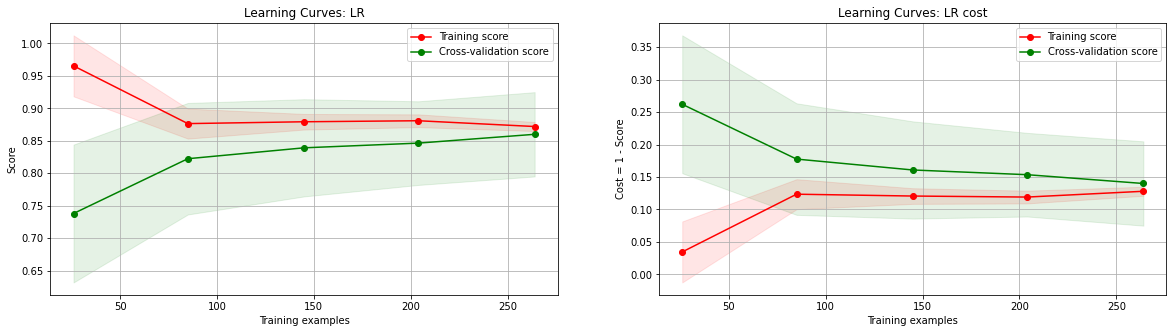

Evaluating all dataset with cross val predict






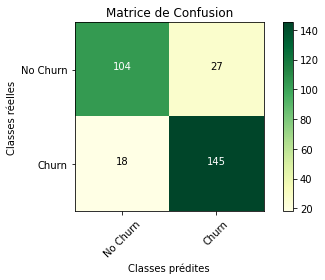

In [8]:
lr = LogisticRegression(max_iter=10000,random_state=2)
Lr_tuple = ("LR",lr)
lr_res = cross_val_monitor(Lr_tuple,X,y)

In [10]:
param_grid = {'C': [1.0,10.0,100.0,1000.0],
              'max_iter':[3000,4000,5000,6000,7000],
              'class_weight': ['balanced',None]
             }
rg_cv = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy',verbose=0)
rg_cv.fit(X, y)
print(rg_cv.best_estimator_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [11]:
rg_cv.best_score_

0.853103448275862

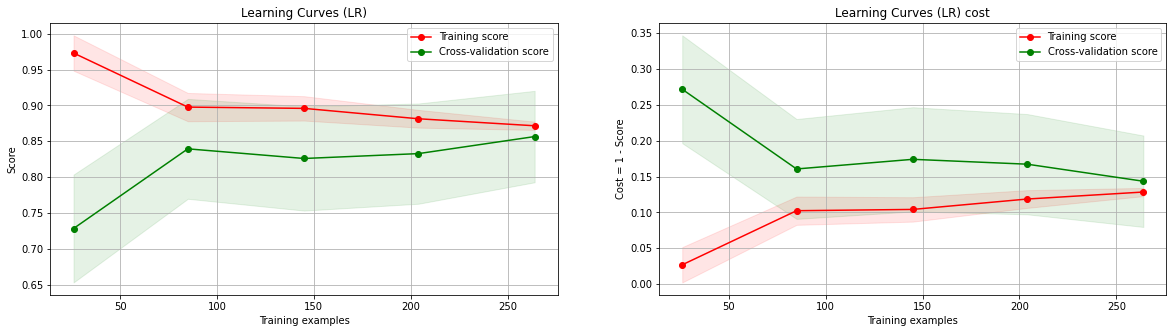

In [19]:
title = f"Learning Curves (LR)"
estimator = rg_cv.best_estimator_
_,score_learning = plot_learning_curve(estimator, title, X, y,
                    cv=10, n_jobs=4)

plt.show()

In [20]:
#Let's interpret the results
lr_coef = pd.DataFrame(np.concatenate([estimator.intercept_.reshape(-1,1),
                             estimator.coef_],axis=1),
             index = ["coef"],
             columns = ["constante"]+list(X.columns)).T

In [21]:
lr_coef.sort_values(by='coef',ascending=False)

coef
ca_0       1.341039
constante  1.240200
cp_3       0.647723
thal_2     0.645824
ca_4       0.639679
cp_2       0.550583
slope_2    0.466924
thal_1     0.397888
restecg_1  0.253169
fbs        0.223364
slope_0    0.101247
thalach    0.018674
age        0.016264
chol      -0.005479
trestbps  -0.017448
restecg_2 -0.057003
cp_1      -0.072089
restecg_0 -0.151308
thal_0    -0.282631
ca_3      -0.350092
oldpeak   -0.421692
slope_1   -0.523312
ca_1      -0.523963
exang     -0.635584
thal_3    -0.716222
ca_2      -1.061806
cp_0      -1.081359
sex       -1.218748

In [22]:
#We choose to test a more complex model
from sklearn import tree

Compute the cross validation on : 294 data split on 5 folds with DT estimator

 Display score: DT
Scores training f1 weighted : 1.0 (+/- 0.0)
Scores test f1 weighted : 0.749 (+/- 0.079)
Scores training accuracy : 1.0 (+/- 0.0)
Scores test accuracy : 0.751 (+/- 0.08)
Scores training roc_auc : 1.0 (+/- 0.0)
Scores test roc_auc : 0.749 (+/- 0.075)
Scores training precision : 1.0 (+/- 0.0)
Scores test precision : 0.783 (+/- 0.065)
Scores training recall : 1.0 (+/- 0.0)
Scores test recall : 0.765 (+/- 0.136)


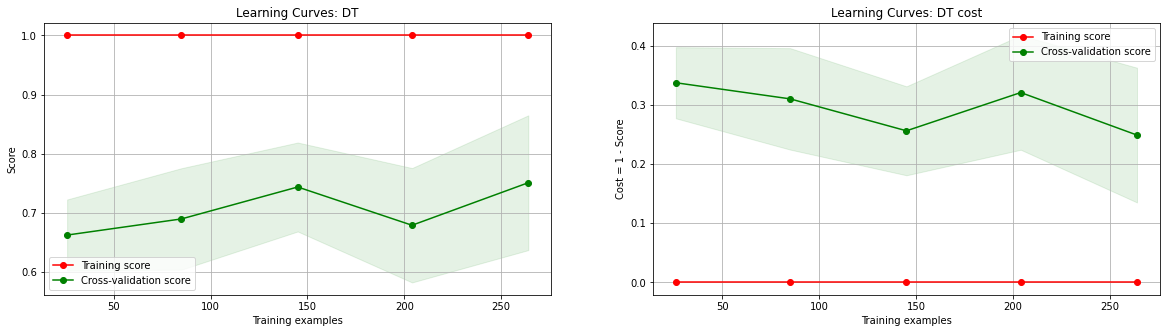

Evaluating all dataset with cross val predict






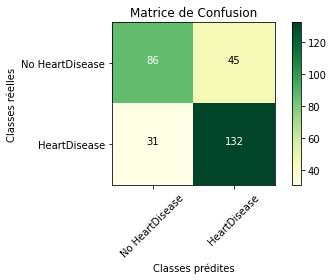

In [23]:
Dt_tuple = ("DT",tree.DecisionTreeClassifier())
Dt_res = cross_val_monitor(Dt_tuple,X,y)

Compute the cross validation on : 294 data split on 5 folds with Ridge estimator

 Display score: Ridge
Scores training f1 weighted : 0.875 (+/- 0.006)
Scores test f1 weighted : 0.855 (+/- 0.055)
Scores training accuracy : 0.876 (+/- 0.006)
Scores test accuracy : 0.857 (+/- 0.053)
Scores training roc_auc : 0.939 (+/- 0.004)
Scores test roc_auc : 0.91 (+/- 0.036)
Scores training precision : 0.858 (+/- 0.007)
Scores test precision : 0.855 (+/- 0.07)
Scores training recall : 0.93 (+/- 0.006)
Scores test recall : 0.901 (+/- 0.042)


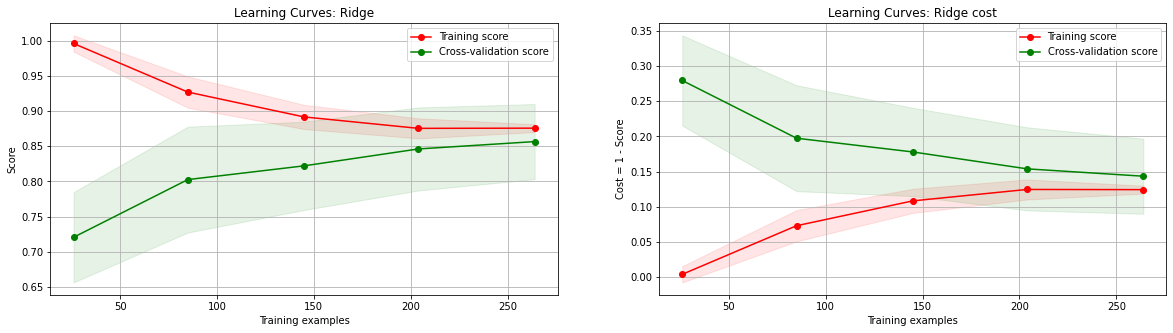

Evaluating all dataset with cross val predict






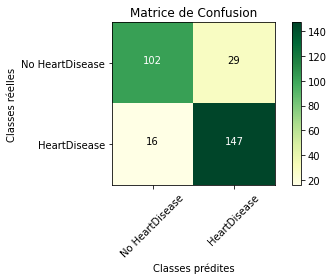

In [48]:
clf_ridge = ("Ridge",RidgeClassifier())
ridge_res = cross_val_monitor(clf_ridge,X,y)

Compute the cross validation on : 294 data split on 5 folds with Knn estimator

 Display score: Knn
Scores training f1 weighted : 0.767 (+/- 0.015)
Scores test f1 weighted : 0.658 (+/- 0.084)
Scores training accuracy : 0.766 (+/- 0.015)
Scores test accuracy : 0.66 (+/- 0.083)
Scores training roc_auc : 0.838 (+/- 0.014)
Scores test roc_auc : 0.695 (+/- 0.103)
Scores training precision : 0.836 (+/- 0.014)
Scores test precision : 0.713 (+/- 0.084)
Scores training recall : 0.72 (+/- 0.02)
Scores test recall : 0.658 (+/- 0.114)


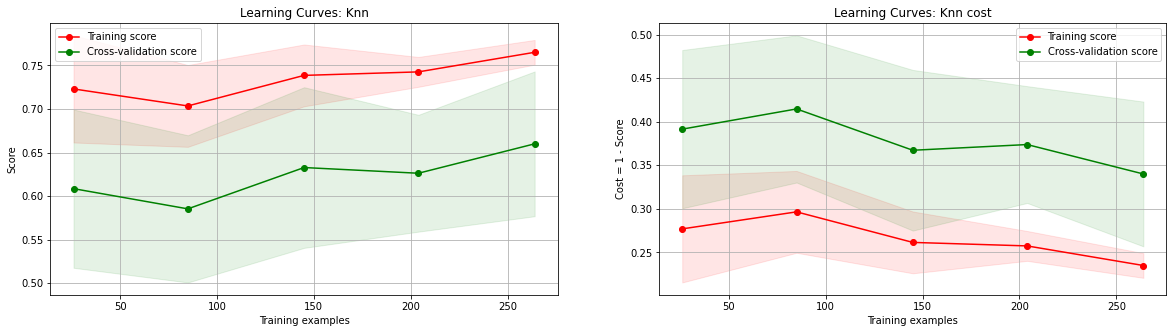

Evaluating all dataset with cross val predict






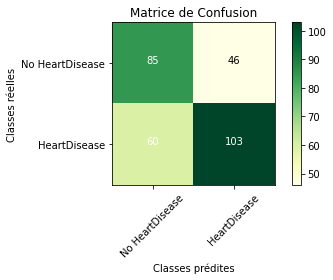

In [24]:
#Less are the neighbors more the model overfitting
from sklearn.neighbors import KNeighborsClassifier
clf_knn = ('Knn',KNeighborsClassifier(n_neighbors=6))
knn_res = cross_val_monitor(clf_knn,X,y)

In [25]:
from sklearn.ensemble import RandomForestClassifier

Compute the cross validation on : 294 data split on 5 folds with Rf estimator

 Display score: Rf
Scores training f1 weighted : 0.884 (+/- 0.009)
Scores test f1 weighted : 0.841 (+/- 0.059)
Scores training accuracy : 0.885 (+/- 0.009)
Scores test accuracy : 0.843 (+/- 0.058)
Scores training roc_auc : 0.947 (+/- 0.005)
Scores test roc_auc : 0.904 (+/- 0.039)
Scores training precision : 0.866 (+/- 0.01)
Scores test precision : 0.843 (+/- 0.068)
Scores training recall : 0.937 (+/- 0.011)
Scores test recall : 0.889 (+/- 0.061)


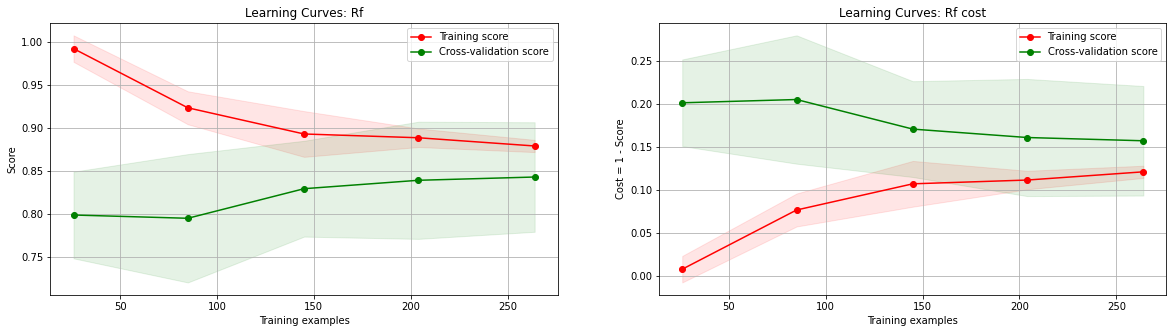

Evaluating all dataset with cross val predict






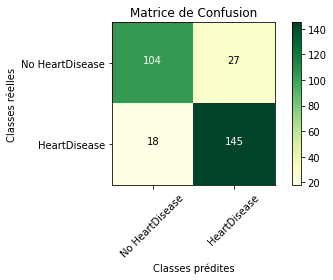

In [26]:
#Regularize decrease variance but could increase variance in the prediction scores 
#Wee see it with the validation curve
rf_regul = ('Rf',RandomForestClassifier(random_state=3,max_depth=3))
rf_res = cross_val_monitor(rf_regul,X,y)

Compute the cross validation on : 294 data split on 5 folds with SVC estimator

 Display score: SVC
Scores training f1 weighted : 0.651 (+/- 0.008)
Scores test f1 weighted : 0.623 (+/- 0.081)
Scores training accuracy : 0.668 (+/- 0.007)
Scores test accuracy : 0.646 (+/- 0.076)
Scores training roc_auc : 0.758 (+/- 0.011)
Scores test roc_auc : 0.741 (+/- 0.099)
Scores training precision : 0.654 (+/- 0.005)
Scores test precision : 0.638 (+/- 0.053)
Scores training recall : 0.854 (+/- 0.008)
Scores test recall : 0.84 (+/- 0.108)


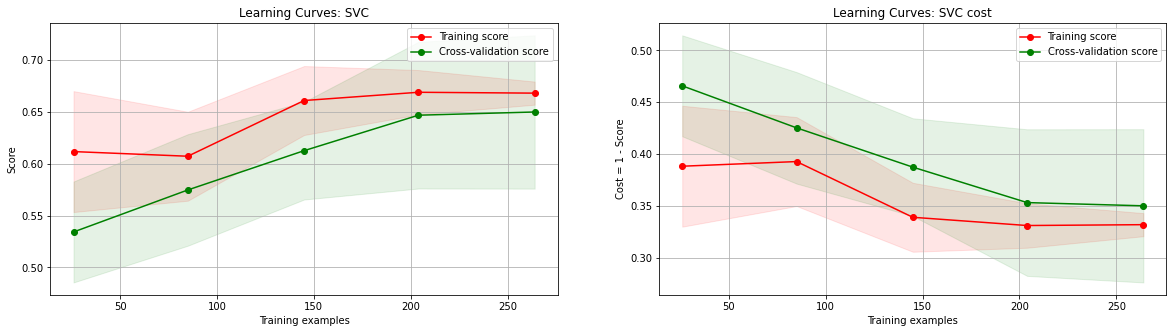

Evaluating all dataset with cross val predict






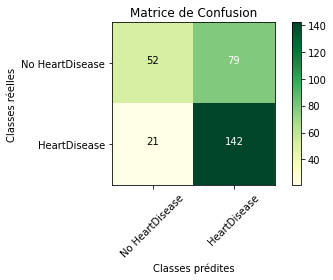

In [27]:
#Here the model underfit at 80% of training data 
from sklearn.svm import SVC
clf_svc = ('SVC',SVC(random_state=2))
#Training curve score decrease 
svm_score = cross_val_monitor(clf_svc,X,y)

Compute the cross validation on : 294 data split on 5 folds with SGD estimator

 Display score: SGD
Scores training f1 weighted : 0.546 (+/- 0.081)
Scores test f1 weighted : 0.491 (+/- 0.084)
Scores training accuracy : 0.615 (+/- 0.035)
Scores test accuracy : 0.572 (+/- 0.063)
Scores training roc_auc : 0.778 (+/- 0.013)
Scores test roc_auc : 0.752 (+/- 0.096)
Scores training precision : 0.671 (+/- 0.125)
Scores test precision : 0.602 (+/- 0.056)
Scores training recall : 0.797 (+/- 0.262)
Scores test recall : 0.758 (+/- 0.334)


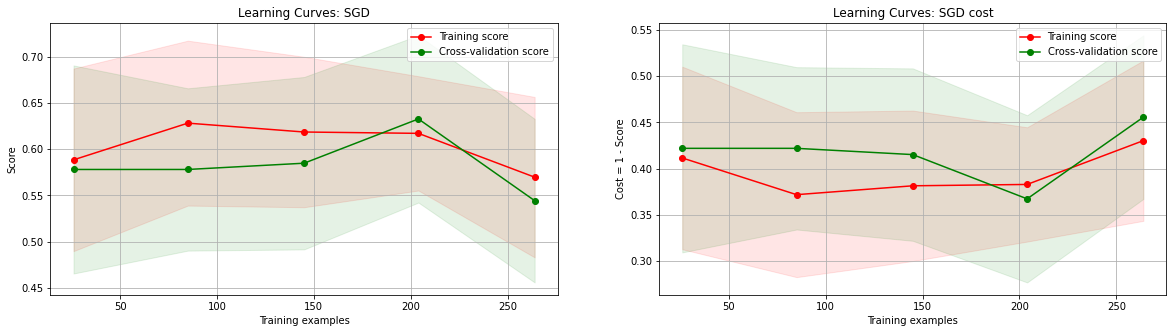

Evaluating all dataset with cross val predict






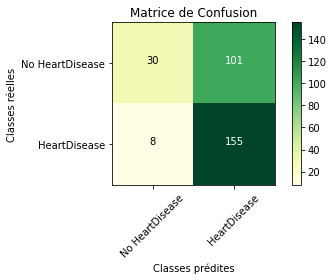

In [28]:
from sklearn.linear_model import SGDClassifier
clf_sgd = ('SGD',SGDClassifier(random_state=5))
sgd_res = cross_val_monitor(clf_sgd,X,y)

Compute the cross validation on : 294 data split on 5 folds with Gb estimator

 Display score: Gb
Scores training f1 weighted : 0.877 (+/- 0.009)
Scores test f1 weighted : 0.838 (+/- 0.06)
Scores training accuracy : 0.878 (+/- 0.009)
Scores test accuracy : 0.84 (+/- 0.059)
Scores training roc_auc : 0.945 (+/- 0.004)
Scores test roc_auc : 0.908 (+/- 0.032)
Scores training precision : 0.869 (+/- 0.01)
Scores test precision : 0.842 (+/- 0.069)
Scores training recall : 0.918 (+/- 0.007)
Scores test recall : 0.883 (+/- 0.074)


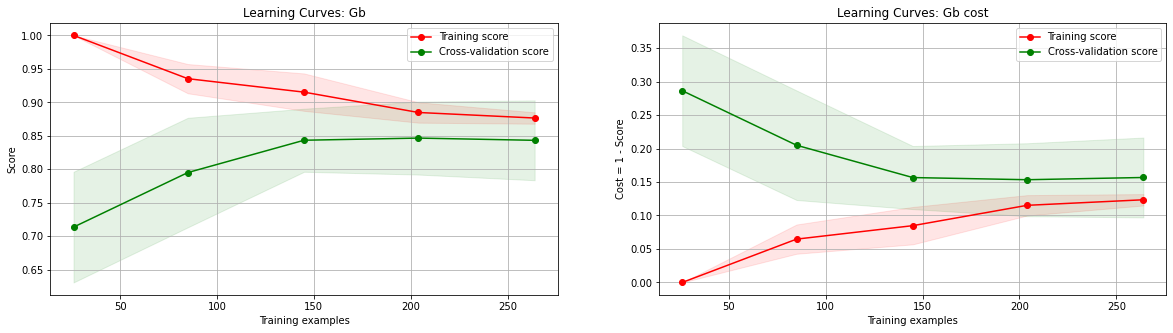

Evaluating all dataset with cross val predict






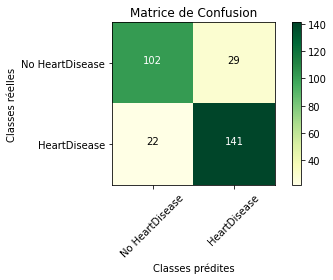

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gb = ('Gb',GradientBoostingClassifier(random_state=4,max_depth=1))
gb_res = cross_val_monitor(clf_gb,X,y)

Compute the cross validation on : 294 data split on 5 folds with Xgb estimator

 Display score: Xgb
Scores training f1 weighted : 0.871 (+/- 0.009)
Scores test f1 weighted : 0.838 (+/- 0.058)
Scores training accuracy : 0.872 (+/- 0.009)
Scores test accuracy : 0.84 (+/- 0.057)
Scores training roc_auc : 0.943 (+/- 0.005)
Scores test roc_auc : 0.912 (+/- 0.03)
Scores training precision : 0.863 (+/- 0.01)
Scores test precision : 0.847 (+/- 0.07)
Scores training recall : 0.913 (+/- 0.007)
Scores test recall : 0.877 (+/- 0.067)


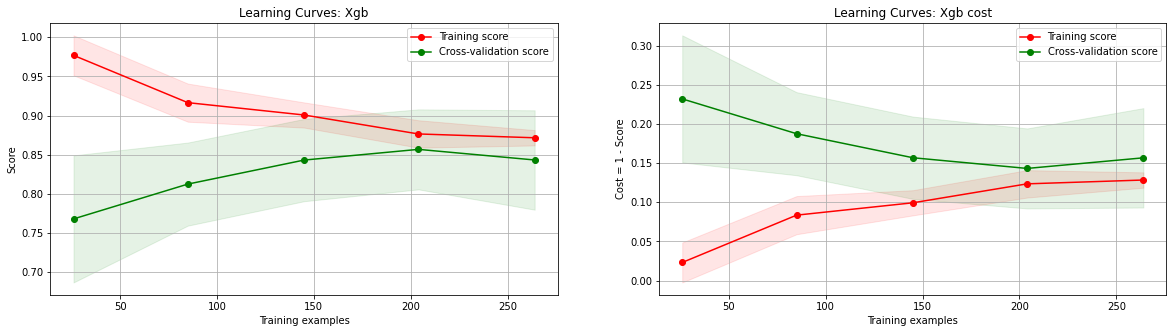

Evaluating all dataset with cross val predict






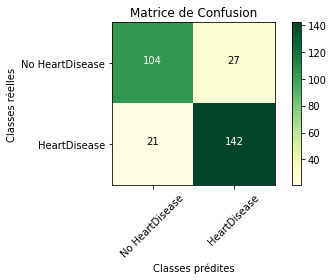

In [30]:
import xgboost as xgb
clf_xg = ('Xgb',xgb.XGBClassifier(random_state=19,max_depth=1))
xg_res = cross_val_monitor(clf_xg,X,y)

Compute the cross validation on : 294 data split on 5 folds with Ada estimator

 Display score: Ada
Scores training f1 weighted : 0.928 (+/- 0.009)
Scores test f1 weighted : 0.812 (+/- 0.093)
Scores training accuracy : 0.928 (+/- 0.009)
Scores test accuracy : 0.815 (+/- 0.09)
Scores training roc_auc : 0.984 (+/- 0.003)
Scores test roc_auc : 0.873 (+/- 0.087)
Scores training precision : 0.928 (+/- 0.011)
Scores test precision : 0.835 (+/- 0.105)
Scores training recall : 0.944 (+/- 0.01)
Scores test recall : 0.851 (+/- 0.098)


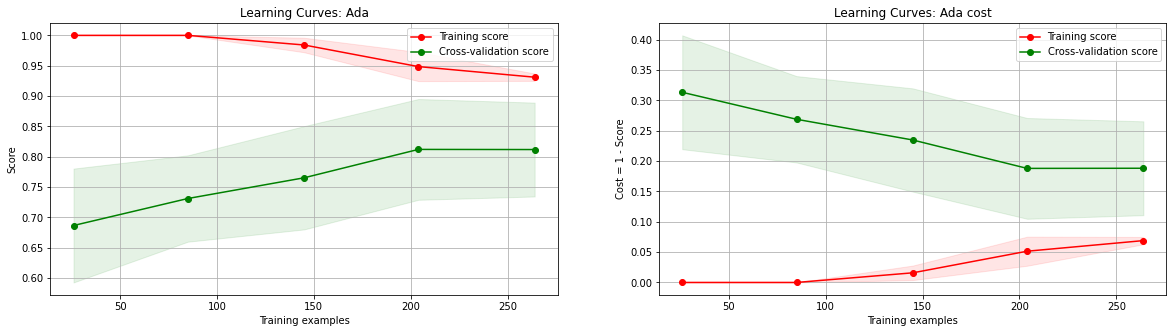

Evaluating all dataset with cross val predict






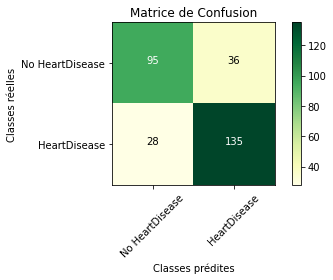

In [31]:
from sklearn.ensemble import AdaBoostClassifier
clf_ada = ('Ada',AdaBoostClassifier(random_state=12))
ada_res = cross_val_monitor(clf_ada,X,y)

Compute the cross validation on : 294 data split on 5 folds with CatB estimator

 Display score: CatB
Scores training f1 weighted : 1.0 (+/- 0.0)
Scores test f1 weighted : 0.825 (+/- 0.062)
Scores training accuracy : 1.0 (+/- 0.0)
Scores test accuracy : 0.826 (+/- 0.062)
Scores training roc_auc : 1.0 (+/- 0.0)
Scores test roc_auc : 0.894 (+/- 0.059)
Scores training precision : 1.0 (+/- 0.0)
Scores test precision : 0.849 (+/- 0.063)
Scores training recall : 1.0 (+/- 0.0)
Scores test recall : 0.839 (+/- 0.102)


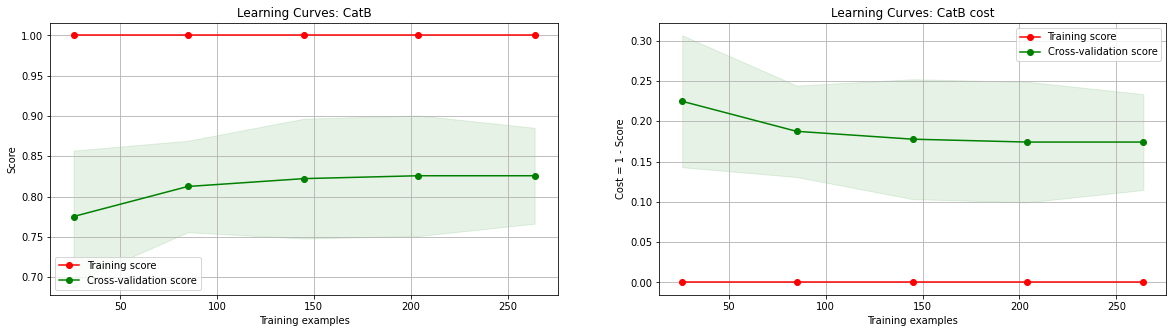

Evaluating all dataset with cross val predict






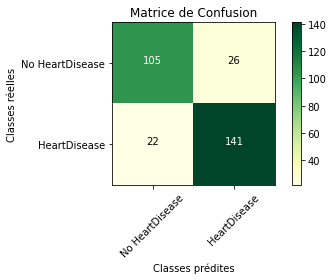

In [32]:
from catboost import CatBoostClassifier
clf_ct = ('CatB',CatBoostClassifier(random_state=5,logging_level='Silent'))
ct_res = cross_val_monitor(clf_ct,X,y)

In [49]:
pd.set_option('display.float_format', '{:,.3f}'.format)
cm = sns.light_palette("green", as_cmap=True)
df_res = pd.concat([lr_res,Dt_res,knn_res,rf_res,svm_score,sgd_res,gb_res,xg_res,ada_res,ct_res,ridge_res],axis=0).reset_index(drop=True)
df_res = df_res.sort_values(by='test_accuracy',ascending=False)
s = df_res.style.background_gradient(cmap=cm)
s

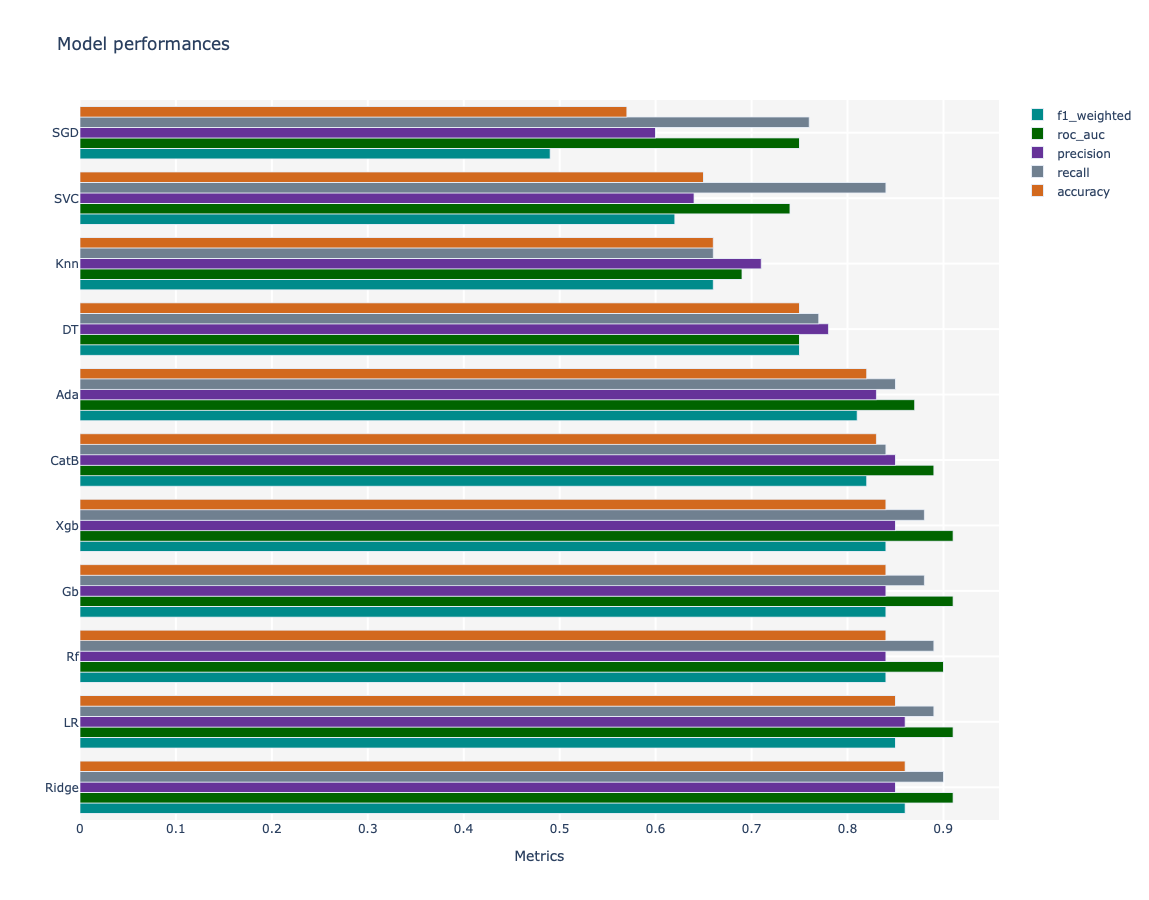

In [50]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
#initate plotly
pyoff.init_notebook_mode()

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor = "whitesmoke",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Metrics",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 900
                       )
                  )


f1_score_w  = plot_performances(df_res,'Model_name',"test_f1_weighted","darkcyan")
roc_auc_s  = plot_performances(df_res,'Model_name','test_roc_auc',"darkgreen")
precision_s  = plot_performances(df_res,'Model_name','test_precision',"rebeccapurple")
recall_s  = plot_performances(df_res,'Model_name','test_recall',"slategray")
accuracy_s  = plot_performances(df_res,'Model_name','test_accuracy',"chocolate")
data = [f1_score_w,roc_auc_s,precision_s,recall_s,accuracy_s]
fig = go.Figure(data=data,layout=layout)
pyoff.iplot(fig)

In [55]:
#Train test split 
#80% train 20% test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,stratify=y,random_state=5)


LR


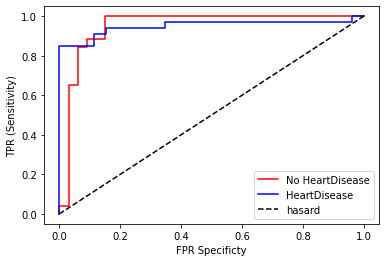

Matrice de confusion :



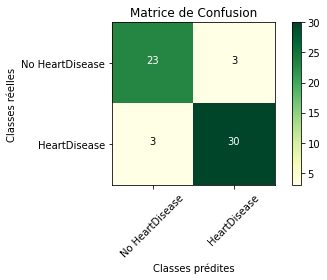

Resultats :

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.91      0.91      0.91        33

    accuracy                           0.90        59
   macro avg       0.90      0.90      0.90        59
weighted avg       0.90      0.90      0.90        59


Xgb


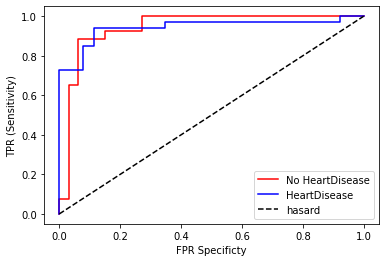

Matrice de confusion :



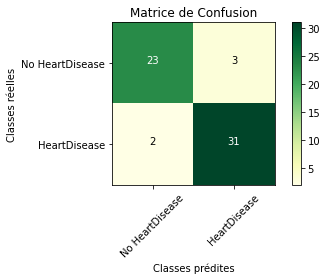

Resultats :

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.91      0.94      0.93        33

    accuracy                           0.92        59
   macro avg       0.92      0.91      0.91        59
weighted avg       0.92      0.92      0.92        59


Ada


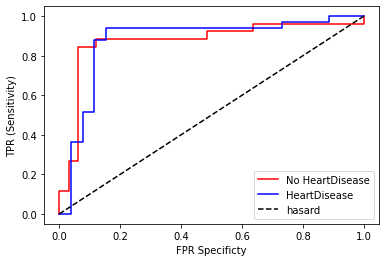

Matrice de confusion :



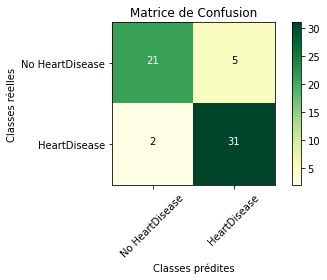

Resultats :

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        26
           1       0.86      0.94      0.90        33

    accuracy                           0.88        59
   macro avg       0.89      0.87      0.88        59
weighted avg       0.88      0.88      0.88        59


Gb


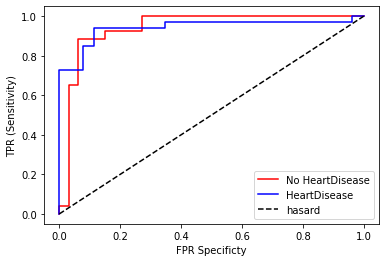

Matrice de confusion :



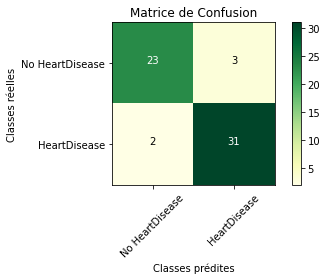

Resultats :

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.91      0.94      0.93        33

    accuracy                           0.92        59
   macro avg       0.92      0.91      0.91        59
weighted avg       0.92      0.92      0.92        59


Rf


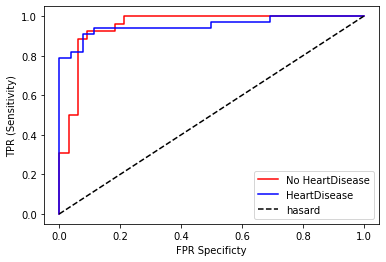

Matrice de confusion :



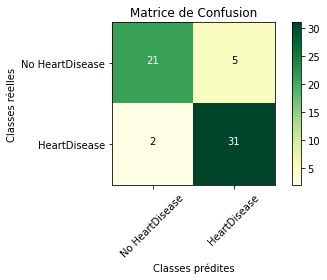

Resultats :

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        26
           1       0.86      0.94      0.90        33

    accuracy                           0.88        59
   macro avg       0.89      0.87      0.88        59
weighted avg       0.88      0.88      0.88        59


Ridge
L'estimator n'a pas de probabilités

Matrice de confusion :



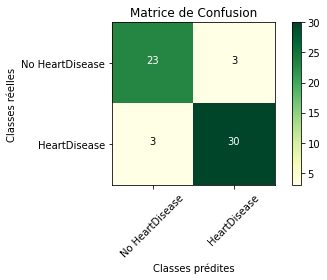

Resultats :

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.91      0.91      0.91        33

    accuracy                           0.90        59
   macro avg       0.90      0.90      0.90        59
weighted avg       0.90      0.90      0.90        59



'le meilleure modèle est : Xgb avec un f1-score de : 0.9150558275422489'

In [56]:
First_clf =  [Lr_tuple,clf_xg,clf_ada,clf_gb,rf_regul,clf_ridge]

compute_performances(First_clf,
            X_train,
            y_train,
            X_test,
            y_test)

<Figure size 720x720 with 0 Axes>

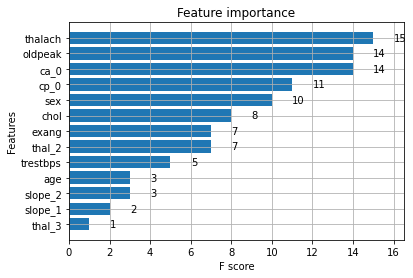

In [57]:
plt.figure(figsize=(10,10))
model_xg = clf_xg[1].fit(X_train,y_train)
xgb.plot_importance(model_xg, max_num_features=15, height=0.8,importance_type='weight')
plt.show()

In [60]:
Lst_clf = [Lr_tuple,clf_sgd,clf_ada,clf_gb,clf_knn,rf_regul,clf_xg,clf_ct,clf_ridge]
pred_df = construct_df_pred(Lst_clf,X_train,y_train,X_test)

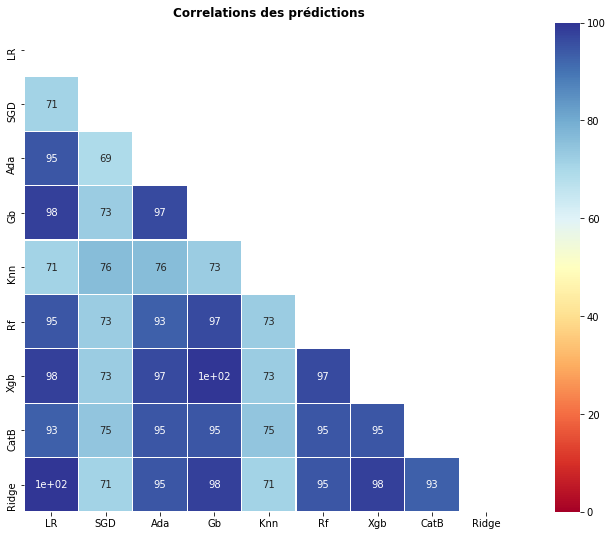

In [61]:
construct_corr_matrix(pred_df,colormap=plt.cm.RdYlBu)

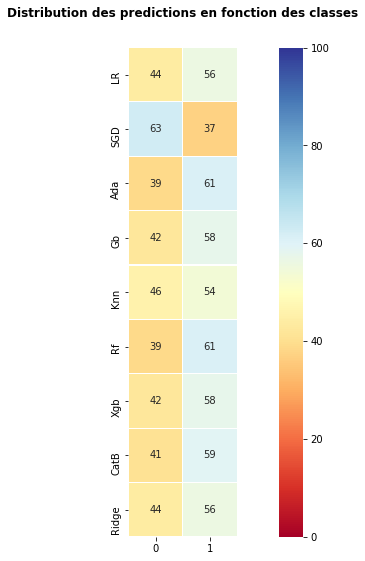

In [62]:
distribution_class(pred_df,colormap=plt.cm.RdYlBu)

In [63]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

Compute the cross validation on : 294 data split on 5 folds with soft estimator

 Display score: soft
Scores training f1 weighted : 0.873 (+/- 0.01)
Scores test f1 weighted : 0.862 (+/- 0.055)
Scores training accuracy : 0.874 (+/- 0.01)
Scores test accuracy : 0.864 (+/- 0.054)
Scores training roc_auc : 0.945 (+/- 0.004)
Scores test roc_auc : 0.914 (+/- 0.032)
Scores training precision : 0.863 (+/- 0.008)
Scores test precision : 0.857 (+/- 0.07)
Scores training recall : 0.918 (+/- 0.011)
Scores test recall : 0.914 (+/- 0.05)


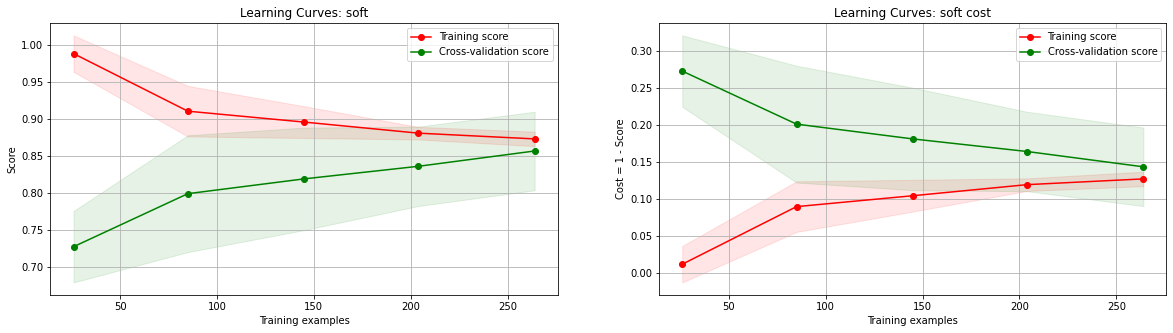

Evaluating all dataset with cross val predict






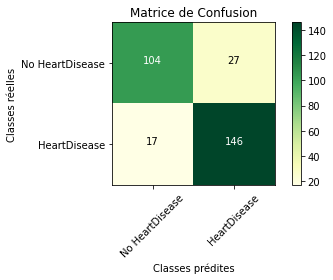

In [80]:
eclf1 = VotingClassifier(estimators=[Lr_tuple,clf_xg,clf_gb], voting='soft')
clf_ens1 = ('soft',eclf1)
clf_ens1_res = cross_val_monitor(clf_ens1,X,y)


soft


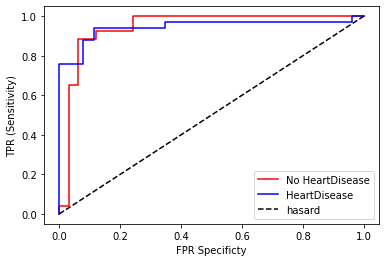

Matrice de confusion :



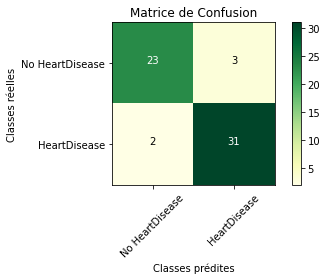

Resultats :

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.91      0.94      0.93        33

    accuracy                           0.92        59
   macro avg       0.92      0.91      0.91        59
weighted avg       0.92      0.92      0.92        59



'le meilleure modèle est : soft avec un f1-score de : 0.9150558275422489'

In [81]:
#Exemple running
#Liste de modèle 
First_clf =  [clf_ens1]

compute_performances(First_clf,
            X_train,
            y_train,
            X_test,
            y_test)

In [77]:
eclf2 = VotingClassifier(estimators=[Lr_tuple,clf_ridge,clf_xg], voting='hard')
clf_ens2 = ('hard',eclf2)
clf_ens2_res = cross_val_score(eclf2,X,y,cv=5,scoring='accuracy')

In [78]:
np.mean(clf_ens2_res)

0.8500876680303916